In [2]:
#!pip3 install neat-python
import os
from tensorflow.keras.datasets import mnist
import numpy as np
import ssl
import neat
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle
import csv
import ssl
import cv2
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

## Global Parameters

In [3]:
# Dataset parameters
DATASET = "MNIST"
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = (16,16)
N_CLASSES_TO_USE = 10

# How many samples to test:
N_SAMPLES_TO_TEST = 200

# Simulation Parameters
NR_GENERATIONS =1000
CONFIG_FILE = 'NEAT-configs/mnist-wann'

## Load MNIST

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## Preprocess MNIST

In [5]:
def preprocess(samples, size, n_samples, unskew=True):
    # Create list of processed images
    processed  = np.empty((n_samples,size[0],size[1]))

    # Unskew and resize
    if unskew == True:    
        for i in range(n_samples):
            processed[i,:,:] = deskew(cv2.resize(samples[i,:,:],size),size)
    return processed

def deskew(image, image_shape, negated=True):
    """ source: https://github.com/vsvinayak/mnist-helper """
  
    # negate the image
    if not negated:
        image = 255-image
    
    # calculate the moments of the image
    m = cv2.moments(image)
    if abs(m['mu02']) < 1e-2:
        return image.copy()
    
    # caclulating the skew
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*image_shape[0]*skew], [0,1,0]])
    img = cv2.warpAffine(image, M, image_shape, flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)  
    return img

n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]

# Rescale and preprocess training and testing data
X_train_processed = preprocess(X_train/255, DESIRED_IMAGE_SIZE, n_samples_train)
X_test_processed = preprocess(X_test/255, DESIRED_IMAGE_SIZE, n_samples_test)
    
    

##### WRAPPING UP #####
    
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_processed.reshape(n_samples_train, np.prod(DESIRED_IMAGE_SIZE))
X_test = X_test_processed.reshape(n_samples_test, np.prod(DESIRED_IMAGE_SIZE))

### Visualize

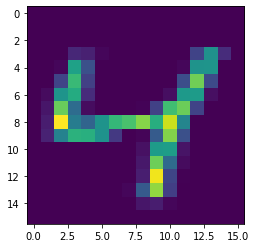

In [6]:
plt.imshow(X_train_processed[2])

# NEAT

## Basic Run Function

In [7]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

# def sigmoid(output):
#     output = [min(709., x) for x in output]
#     output = [max(-709., x) for x in output]
#     return [1 /(1 + exp(-x)) for x in output]

def softmax(output):
    e = exp(output)
    return e / e.sum()

In [8]:
def step(x):
    return 1.0*(x>0.0)

def wann_cos(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.cos(math.pi*x)
    
def wann_sin(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.sin(math.pi * x)
        
def wann_sigmoid(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return (math.tanh(x/2.0) + 1.0)/2.0

def wann_inverse(x):
    return -x

def wann_gauss(x):
    x = max(-3.4, min(3.4, x))
    return exp(- (x*x) / 2.0)
        

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    
    
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    
    p.add_reporter(stats)
    #p.add_reporter(neat.Checkpointer(50, filename_prefix='NEAT-checkpoints/neat-checkpoint-10-classes-'))
    
    
    # Run for up to NR_GENERATIONS generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)
    stats.save_genome_fitness(filename="NEAT-results/fitness_history.csv")
    stats.save_species_count(filename="NEAT-results/species_count.csv")
    with open('NEAT-results/best_genomes', 'wb') as f:
        best_genomes = stats.best_genomes(10)
        pickle.dump(best_genomes,f)
    
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))


## Basic Evaluation Function

In [9]:
def eval_genomes(genomes, config):
    
    def _cross_entropy(pred, label):
        return -np.log(pred[label])
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    nr_nodes = 0
    nr_connections = 0
    for genome_id, genome in genomes:
        nr_nodes +=len(genome.nodes)
        nr_connections +=len(genome.connections)
        
        
        ce = []
        
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = softmax(net.activate(train))
            
            ce.append(-_cross_entropy(output, label))

        genome.fitness = np.average(ce) 
    
    avg_nodes = nr_nodes / float(len(genomes))
    avg_connections = nr_connections / float(len(genomes))
    with open("NEAT-results/sizes_mnist.csv",'a', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([avg_nodes, avg_connections])
    

In [11]:
run(CONFIG_FILE)


 ****** Running generation 0 ****** 

Population's average fitness: -2.92930 stdev: 0.29983
Best fitness: -2.37895 - size: (10, 128) - species 1 - id 70
Average adjusted fitness: 0.662
Mean genetic distance 2.295, standard deviation 0.324
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   250     -2.4    0.662     0
Total extinctions: 0
Generation time: 8.077 sec

 ****** Running generation 1 ****** 

Population's average fitness: -2.83391 stdev: 0.30596
Best fitness: -2.35137 - size: (10, 128) - species 1 - id 339
Average adjusted fitness: 0.710
Mean genetic distance 2.366, standard deviation 0.106
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   250     -2.4    0.710     0
Total extinctions: 0
Generation time: 8.518 sec (8.298 average)

 ****** Running generation 2 ****** 

Population's average fitness: -2.701

Population's average fitness: -2.47315 stdev: 0.15288
Best fitness: -2.18831 - size: (10, 125) - species 1 - id 4311
Average adjusted fitness: 0.549
Mean genetic distance 0.602, standard deviation 0.086
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18   250     -2.2    0.549     0
Total extinctions: 0
Generation time: 8.470 sec (8.412 average)

 ****** Running generation 19 ****** 

Population's average fitness: -2.49135 stdev: 0.14690
Best fitness: -2.21449 - size: (10, 125) - species 1 - id 4311
Average adjusted fitness: 0.525
Mean genetic distance 0.599, standard deviation 0.078
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19   250     -2.2    0.525     1
Total extinctions: 0
Generation time: 8.117 sec (8.364 average)

 ****** Running generation 20 ****** 

Population's average fitness: -2.45542 stdev: 0.16732


Population's average fitness: -2.37861 stdev: 0.13119
Best fitness: -2.07626 - size: (11, 119) - species 1 - id 7032
Average adjusted fitness: 0.474
Mean genetic distance 0.603, standard deviation 0.098
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   36   250     -2.1    0.474     3
Total extinctions: 0
Generation time: 8.264 sec (8.321 average)

 ****** Running generation 37 ****** 

Population's average fitness: -2.39460 stdev: 0.14939
Best fitness: -2.11504 - size: (10, 117) - species 1 - id 7978
Average adjusted fitness: 0.522
Mean genetic distance 0.544, standard deviation 0.080
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   37   250     -2.1    0.522     4
Total extinctions: 0
Generation time: 7.768 sec (8.247 average)

 ****** Running generation 38 ****** 

Population's average fitness: -2.38125 stdev: 0.12416


Mean genetic distance 0.572, standard deviation 0.067
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   53   250     -2.1    0.500    20
Total extinctions: 0
Generation time: 10.831 sec (8.320 average)

 ****** Running generation 54 ****** 

Population's average fitness: -2.38454 stdev: 0.13595
Best fitness: -2.10523 - size: (10, 119) - species 1 - id 13214
Average adjusted fitness: 0.437
Mean genetic distance 0.579, standard deviation 0.078
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   54   250     -2.1    0.437    21
Total extinctions: 0
Generation time: 9.947 sec (8.530 average)

 ****** Running generation 55 ****** 

Population's average fitness: -2.35423 stdev: 0.13125
Best fitness: -2.08017 - size: (11, 119) - species 1 - id 13670
Average adjusted fitness: 0.494
Mean genetic distance 0.594, standard deviation 0.0

Population's average fitness: -2.35653 stdev: 0.14534
Best fitness: -2.07083 - size: (10, 114) - species 1 - id 17770
Average adjusted fitness: 0.626
Mean genetic distance 0.611, standard deviation 0.082
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   71   250     -2.1    0.626     3
Total extinctions: 0
Generation time: 8.045 sec (8.193 average)

 ****** Running generation 72 ****** 

Population's average fitness: -2.29848 stdev: 0.16811
Best fitness: -1.98619 - size: (10, 114) - species 1 - id 17770
Average adjusted fitness: 0.694
Mean genetic distance 0.614, standard deviation 0.081
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   72   250     -2.0    0.694     0
Total extinctions: 0
Generation time: 7.728 sec (8.167 average)

 ****** Running generation 73 ****** 

Population's average fitness: -2.35124 stdev: 0.1370

Population's average fitness: -2.30435 stdev: 0.14410
Best fitness: -2.02236 - size: (11, 119) - species 1 - id 22194
Average adjusted fitness: 0.528
Mean genetic distance 0.613, standard deviation 0.090
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   89   250     -2.0    0.528     3
Total extinctions: 0
Generation time: 8.294 sec (8.110 average)

 ****** Running generation 90 ****** 

Population's average fitness: -2.30351 stdev: 0.14531
Best fitness: -1.99209 - size: (12, 119) - species 1 - id 22102
Average adjusted fitness: 0.513
Mean genetic distance 0.610, standard deviation 0.094
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   90   250     -2.0    0.513     4
Total extinctions: 0
Generation time: 8.065 sec (8.103 average)

 ****** Running generation 91 ****** 

Population's average fitness: -2.34920 stdev: 0.1649

Mean genetic distance 0.533, standard deviation 0.113
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  106   250     -2.0    0.603    20
Total extinctions: 0
Generation time: 8.115 sec (8.226 average)

 ****** Running generation 107 ****** 

Population's average fitness: -2.27830 stdev: 0.14762
Best fitness: -1.95416 - size: (10, 112) - species 1 - id 25284
Average adjusted fitness: 0.601
Mean genetic distance 0.536, standard deviation 0.113
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  107   250     -2.0    0.601     0
Total extinctions: 0
Generation time: 8.055 sec (8.168 average)

 ****** Running generation 108 ****** 

Population's average fitness: -2.29274 stdev: 0.14322
Best fitness: -2.00774 - size: (10, 112) - species 1 - id 25284
Average adjusted fitness: 0.460
Mean genetic distance 0.537, standard deviation 0.

Population's average fitness: -2.29100 stdev: 0.14219
Best fitness: -1.98562 - size: (11, 113) - species 1 - id 29006
Average adjusted fitness: 0.477
Mean genetic distance 0.561, standard deviation 0.094
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  124   250     -2.0    0.477    17
Total extinctions: 0
Generation time: 7.800 sec (8.090 average)

 ****** Running generation 125 ****** 

Population's average fitness: -2.28495 stdev: 0.16071
Best fitness: -1.97466 - size: (11, 113) - species 1 - id 29006
Average adjusted fitness: 0.426
Mean genetic distance 0.575, standard deviation 0.109
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  125   250     -2.0    0.426    18
Total extinctions: 0
Generation time: 7.778 sec (8.020 average)

 ****** Running generation 126 ****** 

Population's average fitness: -2.27531 stdev: 0.14

Population's average fitness: -2.28588 stdev: 0.15903
Best fitness: -1.98166 - size: (12, 112) - species 1 - id 33836
Average adjusted fitness: 0.599
Mean genetic distance 0.659, standard deviation 0.100
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  142   250     -2.0    0.599    12
Total extinctions: 0
Generation time: 8.393 sec (8.031 average)

 ****** Running generation 143 ****** 

Population's average fitness: -2.27462 stdev: 0.14399
Best fitness: -1.93750 - size: (12, 112) - species 1 - id 33836
Average adjusted fitness: 0.405
Mean genetic distance 0.667, standard deviation 0.098
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  143   250     -1.9    0.405    13
Total extinctions: 0
Generation time: 7.911 sec (8.046 average)

 ****** Running generation 144 ****** 

Population's average fitness: -2.26364 stdev: 0.17

Population's average fitness: -2.25555 stdev: 0.13823
Best fitness: -1.94361 - size: (12, 105) - species 1 - id 39909
Average adjusted fitness: 0.440
Mean genetic distance 0.645, standard deviation 0.101
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  160   250     -1.9    0.440    13
Total extinctions: 0
Generation time: 7.775 sec (7.724 average)

 ****** Running generation 161 ****** 

Population's average fitness: -2.27544 stdev: 0.16636
Best fitness: -1.93656 - size: (12, 105) - species 1 - id 39909
Average adjusted fitness: 0.487
Mean genetic distance 0.644, standard deviation 0.100
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  161   250     -1.9    0.487    14
Total extinctions: 0
Generation time: 7.645 sec (7.712 average)

 ****** Running generation 162 ****** 

Population's average fitness: -2.29494 stdev: 0.16

Mean genetic distance 0.565, standard deviation 0.096
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  177   250     -1.9    0.489    13
Total extinctions: 0
Generation time: 7.828 sec (7.570 average)

 ****** Running generation 178 ****** 

Population's average fitness: -2.23171 stdev: 0.18538
Best fitness: -1.84049 - size: (10, 101) - species 1 - id 43768
Average adjusted fitness: 0.573
Mean genetic distance 0.543, standard deviation 0.088
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  178   250     -1.8    0.573     0
Total extinctions: 0
Generation time: 8.018 sec (7.612 average)

 ****** Running generation 179 ****** 

Population's average fitness: -2.25819 stdev: 0.16290
Best fitness: -1.91102 - size: (10, 101) - species 1 - id 43768
Average adjusted fitness: 0.630
Mean genetic distance 0.554, standard deviation 0.

Population's average fitness: -2.22991 stdev: 0.18368
Best fitness: -1.85222 - size: (10, 103) - species 1 - id 46936
Average adjusted fitness: 0.680
Mean genetic distance 0.508, standard deviation 0.096
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  195   250     -1.9    0.680     5
Total extinctions: 0
Generation time: 7.762 sec (7.682 average)

 ****** Running generation 196 ****** 

Population's average fitness: -2.24009 stdev: 0.15071
Best fitness: -1.90739 - size: (10, 103) - species 1 - id 46936
Average adjusted fitness: 0.507
Mean genetic distance 0.484, standard deviation 0.086
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  196   250     -1.9    0.507     6
Total extinctions: 0
Generation time: 7.629 sec (7.676 average)

 ****** Running generation 197 ****** 

Population's average fitness: -2.25045 stdev: 0.16

Population's average fitness: -2.22145 stdev: 0.20480
Best fitness: -1.80800 - size: (12, 100) - species 1 - id 52858
Average adjusted fitness: 0.677
Mean genetic distance 0.526, standard deviation 0.093
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  213   250     -1.8    0.677    23
Total extinctions: 0
Generation time: 7.765 sec (7.791 average)

 ****** Running generation 214 ****** 

Population's average fitness: -2.23392 stdev: 0.16105
Best fitness: -1.87718 - size: (12, 100) - species 1 - id 52858
Average adjusted fitness: 0.518
Mean genetic distance 0.549, standard deviation 0.091
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  214   250     -1.9    0.518    24
Total extinctions: 0
Generation time: 7.481 sec (7.789 average)

 ****** Running generation 215 ****** 

Population's average fitness: -2.23958 stdev: 0.17

Population's average fitness: -2.24878 stdev: 0.15996
Best fitness: -1.86683 - size: (11, 102) - species 1 - id 54286
Average adjusted fitness: 0.447
Mean genetic distance 0.664, standard deviation 0.089
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  231   250     -1.9    0.447    10
Total extinctions: 0
Generation time: 7.791 sec (7.717 average)

 ****** Running generation 232 ****** 

Population's average fitness: -2.22446 stdev: 0.17516
Best fitness: -1.82290 - size: (11, 102) - species 1 - id 54286
Average adjusted fitness: 0.579
Mean genetic distance 0.675, standard deviation 0.078
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  232   250     -1.8    0.579    11
Total extinctions: 0
Generation time: 7.599 sec (7.719 average)

 ****** Running generation 233 ****** 

Population's average fitness: -2.23186 stdev: 0.17

Population's average fitness: -2.22266 stdev: 0.15664
Best fitness: -1.82272 - size: (11, 102) - species 1 - id 54286
Average adjusted fitness: 0.485
Mean genetic distance 0.577, standard deviation 0.070
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  249   250     -1.8    0.485    28
Total extinctions: 0
Generation time: 7.436 sec (7.677 average)

 ****** Running generation 250 ****** 

Population's average fitness: -2.23989 stdev: 0.15165
Best fitness: -1.88303 - size: (11, 91) - species 1 - id 61606
Average adjusted fitness: 0.400
Mean genetic distance 0.584, standard deviation 0.079
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  250   250     -1.9    0.400    29
Total extinctions: 0
Generation time: 7.324 sec (7.653 average)

 ****** Running generation 251 ****** 

Population's average fitness: -2.26405 stdev: 0.143

Population's average fitness: -2.21954 stdev: 0.14664
Best fitness: -1.88682 - size: (10, 91) - species 1 - id 64436
Average adjusted fitness: 0.413
Mean genetic distance 0.545, standard deviation 0.098
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  267   250     -1.9    0.413    15
Total extinctions: 0
Generation time: 7.244 sec (7.243 average)

 ****** Running generation 268 ****** 

Population's average fitness: -2.22316 stdev: 0.16533
Best fitness: -1.86988 - size: (10, 91) - species 1 - id 64436
Average adjusted fitness: 0.547
Mean genetic distance 0.555, standard deviation 0.113
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  268   250     -1.9    0.547    16
Total extinctions: 0
Generation time: 7.292 sec (7.246 average)

 ****** Running generation 269 ****** 

Population's average fitness: -2.23140 stdev: 0.1545

Population's average fitness: -2.23532 stdev: 0.16436
Best fitness: -1.82710 - size: (10, 91) - species 1 - id 70512
Average adjusted fitness: 0.541
Mean genetic distance 0.537, standard deviation 0.080
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  285   250     -1.8    0.541    33
Total extinctions: 0
Generation time: 7.151 sec (7.219 average)

 ****** Running generation 286 ****** 

Population's average fitness: -2.23889 stdev: 0.17575
Best fitness: -1.80840 - size: (10, 91) - species 1 - id 70512
Average adjusted fitness: 0.538
Mean genetic distance 0.536, standard deviation 0.082
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  286   250     -1.8    0.538    34
Total extinctions: 0
Generation time: 7.262 sec (7.227 average)

 ****** Running generation 287 ****** 

Population's average fitness: -2.23288 stdev: 0.1803

Mean genetic distance 0.576, standard deviation 0.108
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  302   250     -1.8    0.573     0
Total extinctions: 0
Generation time: 7.419 sec (7.232 average)

 ****** Running generation 303 ****** 

Population's average fitness: -2.22848 stdev: 0.17690
Best fitness: -1.83324 - size: (10, 91) - species 1 - id 73187
Average adjusted fitness: 0.545
Mean genetic distance 0.540, standard deviation 0.125
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  303   250     -1.8    0.545     1
Total extinctions: 0
Generation time: 7.224 sec (7.242 average)

 ****** Running generation 304 ****** 

Population's average fitness: -2.19145 stdev: 0.18364
Best fitness: -1.80119 - size: (12, 95) - species 1 - id 74442
Average adjusted fitness: 0.628
Mean genetic distance 0.540, standard deviation 0.11

Population's average fitness: -2.21420 stdev: 0.19201
Best fitness: -1.76072 - size: (10, 89) - species 1 - id 78094
Average adjusted fitness: 0.552
Mean genetic distance 0.633, standard deviation 0.085
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  320   250     -1.8    0.552     1
Total extinctions: 0
Generation time: 7.107 sec (7.149 average)

 ****** Running generation 321 ****** 

Population's average fitness: -2.25908 stdev: 0.18140
Best fitness: -1.81012 - size: (10, 89) - species 1 - id 78094
Average adjusted fitness: 0.503
Mean genetic distance 0.616, standard deviation 0.087
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  321   250     -1.8    0.503     2
Total extinctions: 0
Generation time: 7.377 sec (7.188 average)

 ****** Running generation 322 ****** 

Population's average fitness: -2.24931 stdev: 0.1770

Mean genetic distance 0.528, standard deviation 0.072
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  337   250     -1.8    0.612     2
Total extinctions: 0
Generation time: 7.244 sec (7.099 average)

 ****** Running generation 338 ****** 

Population's average fitness: -2.19212 stdev: 0.18399
Best fitness: -1.78337 - size: (10, 89) - species 1 - id 78094
Average adjusted fitness: 0.532
Mean genetic distance 0.514, standard deviation 0.069
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  338   250     -1.8    0.532     3
Total extinctions: 0
Generation time: 7.029 sec (7.092 average)

 ****** Running generation 339 ****** 

Population's average fitness: -2.20150 stdev: 0.17058
Best fitness: -1.82629 - size: (10, 89) - species 1 - id 78094
Average adjusted fitness: 0.409
Mean genetic distance 0.500, standard deviation 0.06

Population's average fitness: -2.22129 stdev: 0.20030
Best fitness: -1.80270 - size: (10, 84) - species 1 - id 86036
Average adjusted fitness: 0.597
Mean genetic distance 0.551, standard deviation 0.071
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  355   250     -1.8    0.597     3
Total extinctions: 0
Generation time: 7.116 sec (7.125 average)

 ****** Running generation 356 ****** 

Population's average fitness: -2.22955 stdev: 0.19467
Best fitness: -1.81112 - size: (10, 84) - species 1 - id 86036
Average adjusted fitness: 0.672
Mean genetic distance 0.541, standard deviation 0.075
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  356   250     -1.8    0.672     4
Total extinctions: 0
Generation time: 7.094 sec (7.131 average)

 ****** Running generation 357 ****** 

Population's average fitness: -2.18514 stdev: 0.2070

Population's average fitness: -2.19166 stdev: 0.18606
Best fitness: -1.76159 - size: (11, 87) - species 1 - id 86445
Average adjusted fitness: 0.603
Mean genetic distance 0.601, standard deviation 0.075
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  373   250     -1.8    0.603    21
Total extinctions: 0
Generation time: 7.122 sec (7.130 average)

 ****** Running generation 374 ****** 

Population's average fitness: -2.21197 stdev: 0.19226
Best fitness: -1.76858 - size: (11, 89) - species 1 - id 93002
Average adjusted fitness: 0.563
Mean genetic distance 0.599, standard deviation 0.072
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  374   250     -1.8    0.563    22
Total extinctions: 0
Generation time: 7.033 sec (7.127 average)

 ****** Running generation 375 ****** 

Population's average fitness: -2.19499 stdev: 0.1836

Mean genetic distance 0.615, standard deviation 0.113
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  390   250     -1.8    0.632    38
Total extinctions: 0
Generation time: 7.367 sec (7.353 average)

 ****** Running generation 391 ****** 

Population's average fitness: -2.23321 stdev: 0.18103
Best fitness: -1.80143 - size: (12, 91) - species 1 - id 93271
Average adjusted fitness: 0.577
Mean genetic distance 0.598, standard deviation 0.109
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  391   250     -1.8    0.577    39
Total extinctions: 0
Generation time: 7.235 sec (7.350 average)

 ****** Running generation 392 ****** 

Population's average fitness: -2.23273 stdev: 0.18417
Best fitness: -1.77392 - size: (12, 91) - species 1 - id 93271
Average adjusted fitness: 0.640
Mean genetic distance 0.612, standard deviation 0.11

Population's average fitness: -2.20504 stdev: 0.19663
Best fitness: -1.73944 - size: (12, 93) - species 1 - id 98434
Average adjusted fitness: 0.594
Mean genetic distance 0.579, standard deviation 0.132
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  408   250     -1.7    0.594    56
Total extinctions: 0
Generation time: 7.264 sec (7.220 average)

 ****** Running generation 409 ****** 

Population's average fitness: -2.20242 stdev: 0.20480
Best fitness: -1.73357 - size: (12, 93) - species 1 - id 99674
Average adjusted fitness: 0.574
Mean genetic distance 0.546, standard deviation 0.115
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  409   250     -1.7    0.574    57
Total extinctions: 0
Generation time: 7.409 sec (7.251 average)

 ****** Running generation 410 ****** 

Population's average fitness: -2.21347 stdev: 0.1905

Population's average fitness: -2.22463 stdev: 0.18681
Best fitness: -1.81204 - size: (12, 93) - species 1 - id 99674
Average adjusted fitness: 0.587
Mean genetic distance 0.590, standard deviation 0.106
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  426   250     -1.8    0.587    74
Total extinctions: 0
Generation time: 7.493 sec (7.401 average)

 ****** Running generation 427 ****** 

Population's average fitness: -2.21092 stdev: 0.19814
Best fitness: -1.74711 - size: (11, 90) - species 1 - id 105372
Average adjusted fitness: 0.597
Mean genetic distance 0.597, standard deviation 0.108
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  427   250     -1.7    0.597    75
Total extinctions: 0
Generation time: 7.258 sec (7.384 average)

 ****** Running generation 428 ****** 

Population's average fitness: -2.22236 stdev: 0.172

Population's average fitness: -2.17478 stdev: 0.19344
Best fitness: -1.69470 - size: (11, 90) - species 1 - id 109854
Average adjusted fitness: 0.532
Mean genetic distance 0.546, standard deviation 0.110
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  444   250     -1.7    0.532     0
Total extinctions: 0
Generation time: 7.029 sec (7.096 average)

 ****** Running generation 445 ****** 

Population's average fitness: -2.20608 stdev: 0.19377
Best fitness: -1.74595 - size: (11, 90) - species 1 - id 109854
Average adjusted fitness: 0.550
Mean genetic distance 0.558, standard deviation 0.119
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  445   250     -1.7    0.550     1
Total extinctions: 0
Generation time: 7.127 sec (7.105 average)

 ****** Running generation 446 ****** 

Population's average fitness: -2.22701 stdev: 0.19

Population's average fitness: -2.23433 stdev: 0.18235
Best fitness: -1.80340 - size: (10, 89) - species 1 - id 114108
Average adjusted fitness: 0.553
Mean genetic distance 0.541, standard deviation 0.105
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  462   250     -1.8    0.553    18
Total extinctions: 0
Generation time: 7.288 sec (7.279 average)

 ****** Running generation 463 ****** 

Population's average fitness: -2.20724 stdev: 0.18876
Best fitness: -1.74024 - size: (11, 87) - species 1 - id 111782
Average adjusted fitness: 0.533
Mean genetic distance 0.545, standard deviation 0.101
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  463   250     -1.7    0.533    19
Total extinctions: 0
Generation time: 6.928 sec (7.245 average)

 ****** Running generation 464 ****** 

Population's average fitness: -2.21621 stdev: 0.18

Population's average fitness: -2.19709 stdev: 0.19745
Best fitness: -1.72743 - size: (12, 86) - species 1 - id 116697
Average adjusted fitness: 0.565
Mean genetic distance 0.562, standard deviation 0.102
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  480   250     -1.7    0.565    10
Total extinctions: 0
Generation time: 7.244 sec (7.193 average)

 ****** Running generation 481 ****** 

Population's average fitness: -2.24895 stdev: 0.19188
Best fitness: -1.80475 - size: (12, 86) - species 1 - id 116697
Average adjusted fitness: 0.646
Mean genetic distance 0.574, standard deviation 0.099
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  481   250     -1.8    0.646    11
Total extinctions: 0
Generation time: 7.132 sec (7.175 average)

 ****** Running generation 482 ****** 

Population's average fitness: -2.20440 stdev: 0.18

Mean genetic distance 0.567, standard deviation 0.115
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  497   250     -1.7    0.477    27
Total extinctions: 0
Generation time: 7.763 sec (7.208 average)

 ****** Running generation 498 ****** 

Population's average fitness: -2.19420 stdev: 0.21342
Best fitness: -1.71333 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.591
Mean genetic distance 0.555, standard deviation 0.115
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  498   250     -1.7    0.591    28
Total extinctions: 0
Generation time: 7.455 sec (7.235 average)

 ****** Running generation 499 ****** 

Population's average fitness: -2.26108 stdev: 0.17370
Best fitness: -1.82785 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.529
Mean genetic distance 0.581, standard deviation 0.

Population's average fitness: -2.20396 stdev: 0.18400
Best fitness: -1.77819 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.645
Mean genetic distance 0.539, standard deviation 0.127
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  515   250     -1.8    0.645    45
Total extinctions: 0
Generation time: 7.289 sec (7.223 average)

 ****** Running generation 516 ****** 

Population's average fitness: -2.21998 stdev: 0.19040
Best fitness: -1.80487 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.621
Mean genetic distance 0.572, standard deviation 0.127
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  516   250     -1.8    0.621    46
Total extinctions: 0
Generation time: 7.158 sec (7.202 average)

 ****** Running generation 517 ****** 

Population's average fitness: -2.21006 stdev: 0.19

Population's average fitness: -2.21800 stdev: 0.20048
Best fitness: -1.75298 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.568
Mean genetic distance 0.528, standard deviation 0.116
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  533   250     -1.8    0.568    63
Total extinctions: 0
Generation time: 7.393 sec (7.372 average)

 ****** Running generation 534 ****** 

Population's average fitness: -2.17897 stdev: 0.19731
Best fitness: -1.72407 - size: (12, 88) - species 1 - id 129364
Average adjusted fitness: 0.573
Mean genetic distance 0.515, standard deviation 0.106
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  534   250     -1.7    0.573    64
Total extinctions: 0
Generation time: 7.074 sec (7.354 average)

 ****** Running generation 535 ****** 

Population's average fitness: -2.18981 stdev: 0.18

Mean genetic distance 0.543, standard deviation 0.105
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  550   250     -1.9    0.622    80
Total extinctions: 0
Generation time: 7.531 sec (7.476 average)

 ****** Running generation 551 ****** 

Population's average fitness: -2.21653 stdev: 0.19484
Best fitness: -1.76137 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.609
Mean genetic distance 0.560, standard deviation 0.115
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  551   250     -1.8    0.609    81
Total extinctions: 0
Generation time: 7.385 sec (7.474 average)

 ****** Running generation 552 ****** 

Population's average fitness: -2.19929 stdev: 0.18133
Best fitness: -1.77776 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.593
Mean genetic distance 0.565, standard deviation 0.

Population's average fitness: -2.23536 stdev: 0.19812
Best fitness: -1.75946 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.538
Mean genetic distance 0.561, standard deviation 0.123
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  568   250     -1.8    0.538    98
Total extinctions: 0
Generation time: 7.232 sec (7.350 average)

 ****** Running generation 569 ****** 

Population's average fitness: -2.19956 stdev: 0.17436
Best fitness: -1.77670 - size: (12, 88) - species 1 - id 129364
Average adjusted fitness: 0.549
Mean genetic distance 0.546, standard deviation 0.122
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  569   250     -1.8    0.549    99
Total extinctions: 0
Generation time: 7.250 sec (7.326 average)

 ****** Running generation 570 ****** 

Population's average fitness: -2.20311 stdev: 0.17

Mean genetic distance 0.549, standard deviation 0.095
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  585   250     -1.7    0.586   115
Total extinctions: 0
Generation time: 7.246 sec (7.348 average)

 ****** Running generation 586 ****** 

Population's average fitness: -2.19858 stdev: 0.19325
Best fitness: -1.75155 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.605
Mean genetic distance 0.550, standard deviation 0.104
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  586   250     -1.8    0.605   116
Total extinctions: 0
Generation time: 7.072 sec (7.326 average)

 ****** Running generation 587 ****** 

Population's average fitness: -2.23651 stdev: 0.16879
Best fitness: -1.80238 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.566
Mean genetic distance 0.565, standard deviation 0.

Population's average fitness: -2.22904 stdev: 0.19173
Best fitness: -1.79985 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.576
Mean genetic distance 0.522, standard deviation 0.110
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  603   250     -1.8    0.576   133
Total extinctions: 0
Generation time: 6.919 sec (7.147 average)

 ****** Running generation 604 ****** 

Population's average fitness: -2.17286 stdev: 0.19468
Best fitness: -1.77138 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.678
Mean genetic distance 0.514, standard deviation 0.110
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  604   250     -1.8    0.678   134
Total extinctions: 0
Generation time: 7.172 sec (7.126 average)

 ****** Running generation 605 ****** 

Population's average fitness: -2.22141 stdev: 0.18

Population's average fitness: -2.22586 stdev: 0.18126
Best fitness: -1.78907 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.578
Mean genetic distance 0.559, standard deviation 0.120
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  621   250     -1.8    0.578   151
Total extinctions: 0
Generation time: 7.328 sec (7.114 average)

 ****** Running generation 622 ****** 

Population's average fitness: -2.19631 stdev: 0.16285
Best fitness: -1.78268 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.448
Mean genetic distance 0.545, standard deviation 0.112
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  622   250     -1.8    0.448   152
Total extinctions: 0
Generation time: 6.921 sec (7.093 average)

 ****** Running generation 623 ****** 

Population's average fitness: -2.19692 stdev: 0.20

Population's average fitness: -2.19075 stdev: 0.20132
Best fitness: -1.76586 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.586
Mean genetic distance 0.586, standard deviation 0.115
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  639   250     -1.8    0.586   169
Total extinctions: 0
Generation time: 7.078 sec (7.124 average)

 ****** Running generation 640 ****** 

Population's average fitness: -2.23469 stdev: 0.21993
Best fitness: -1.78179 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.610
Mean genetic distance 0.558, standard deviation 0.113
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  640   250     -1.8    0.610   170
Total extinctions: 0
Generation time: 6.876 sec (7.102 average)

 ****** Running generation 641 ****** 

Population's average fitness: -2.19636 stdev: 0.19

Population's average fitness: -2.22699 stdev: 0.16869
Best fitness: -1.81028 - size: (11, 82) - species 1 - id 161791
Average adjusted fitness: 0.620
Mean genetic distance 0.526, standard deviation 0.099
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  657   250     -1.8    0.620   187
Total extinctions: 0
Generation time: 7.044 sec (7.122 average)

 ****** Running generation 658 ****** 

Population's average fitness: -2.17549 stdev: 0.20015
Best fitness: -1.70526 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.539
Mean genetic distance 0.539, standard deviation 0.111
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  658   250     -1.7    0.539   188
Total extinctions: 0
Generation time: 7.211 sec (7.137 average)

 ****** Running generation 659 ****** 

Population's average fitness: -2.19283 stdev: 0.18

Population's average fitness: -2.23370 stdev: 0.19859
Best fitness: -1.77676 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.576
Mean genetic distance 0.573, standard deviation 0.134
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  675   250     -1.8    0.576   205
Total extinctions: 0
Generation time: 7.244 sec (7.355 average)

 ****** Running generation 676 ****** 

Population's average fitness: -2.21358 stdev: 0.17781
Best fitness: -1.79529 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.590
Mean genetic distance 0.548, standard deviation 0.128
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  676   250     -1.8    0.590   206
Total extinctions: 0
Generation time: 7.478 sec (7.385 average)

 ****** Running generation 677 ****** 

Population's average fitness: -2.23277 stdev: 0.17

Population's average fitness: -2.23666 stdev: 0.18546
Best fitness: -1.82657 - size: (10, 84) - species 1 - id 171349
Average adjusted fitness: 0.592
Mean genetic distance 0.570, standard deviation 0.103
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  693   250     -1.8    0.592   223
Total extinctions: 0
Generation time: 7.256 sec (7.216 average)

 ****** Running generation 694 ****** 

Population's average fitness: -2.21409 stdev: 0.17780
Best fitness: -1.79825 - size: (10, 84) - species 1 - id 171349
Average adjusted fitness: 0.549
Mean genetic distance 0.561, standard deviation 0.117
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  694   250     -1.8    0.549   224
Total extinctions: 0
Generation time: 7.700 sec (7.271 average)

 ****** Running generation 695 ****** 

Population's average fitness: -2.20693 stdev: 0.20

Population's average fitness: -2.22080 stdev: 0.19113
Best fitness: -1.73892 - size: (10, 82) - species 1 - id 172464
Average adjusted fitness: 0.485
Mean genetic distance 0.546, standard deviation 0.098
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  711   250     -1.7    0.485     3
Total extinctions: 0
Generation time: 7.185 sec (7.337 average)

 ****** Running generation 712 ****** 

Population's average fitness: -2.20742 stdev: 0.19641
Best fitness: -1.75398 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.584
Mean genetic distance 0.555, standard deviation 0.092
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  712   250     -1.8    0.584     4
Total extinctions: 0
Generation time: 7.413 sec (7.326 average)

 ****** Running generation 713 ****** 

Population's average fitness: -2.22430 stdev: 0.17

Population's average fitness: -2.18492 stdev: 0.19220
Best fitness: -1.70794 - size: (11, 86) - species 1 - id 116075
Average adjusted fitness: 0.547
Mean genetic distance 0.554, standard deviation 0.117
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  729   250     -1.7    0.547    21
Total extinctions: 0
Generation time: 7.719 sec (7.487 average)

 ****** Running generation 730 ****** 

Population's average fitness: -2.22124 stdev: 0.17882
Best fitness: -1.77081 - size: (10, 82) - species 1 - id 172464
Average adjusted fitness: 0.465
Mean genetic distance 0.563, standard deviation 0.129
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  730   250     -1.8    0.465    22
Total extinctions: 0
Generation time: 7.639 sec (7.516 average)

 ****** Running generation 731 ****** 

Population's average fitness: -2.20454 stdev: 0.18

Mean genetic distance 0.616, standard deviation 0.100
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  746   250     -1.8    0.560    38
Total extinctions: 0
Generation time: 7.271 sec (7.423 average)

 ****** Running generation 747 ****** 

Population's average fitness: -2.20891 stdev: 0.18812
Best fitness: -1.77964 - size: (10, 83) - species 1 - id 185090
Average adjusted fitness: 0.527
Mean genetic distance 0.629, standard deviation 0.092
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  747   250     -1.8    0.527    39
Total extinctions: 0
Generation time: 7.264 sec (7.389 average)

 ****** Running generation 748 ****** 

Population's average fitness: -2.20860 stdev: 0.20489
Best fitness: -1.74888 - size: (10, 83) - species 1 - id 185090
Average adjusted fitness: 0.583
Mean genetic distance 0.610, standard deviation 0.

Population's average fitness: -2.19769 stdev: 0.20558
Best fitness: -1.72173 - size: (10, 82) - species 1 - id 187756
Average adjusted fitness: 0.576
Mean genetic distance 0.566, standard deviation 0.084
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  764   250     -1.7    0.576    56
Total extinctions: 0
Generation time: 7.293 sec (7.278 average)

 ****** Running generation 765 ****** 

Population's average fitness: -2.19780 stdev: 0.20353
Best fitness: -1.71530 - size: (10, 82) - species 1 - id 187756
Average adjusted fitness: 0.592
Mean genetic distance 0.569, standard deviation 0.078
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  765   250     -1.7    0.592    57
Total extinctions: 0
Generation time: 7.261 sec (7.278 average)

 ****** Running generation 766 ****** 

Population's average fitness: -2.22114 stdev: 0.18

Population's average fitness: -2.21441 stdev: 0.18334
Best fitness: -1.77780 - size: (10, 85) - species 1 - id 191352
Average adjusted fitness: 0.506
Mean genetic distance 0.476, standard deviation 0.081
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  782   250     -1.8    0.506    74
Total extinctions: 0
Generation time: 7.240 sec (7.333 average)

 ****** Running generation 783 ****** 

Population's average fitness: -2.20790 stdev: 0.19410
Best fitness: -1.74918 - size: (10, 85) - species 1 - id 191352
Average adjusted fitness: 0.569
Mean genetic distance 0.484, standard deviation 0.085
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  783   250     -1.7    0.569    75
Total extinctions: 0
Generation time: 7.199 sec (7.323 average)

 ****** Running generation 784 ****** 

Population's average fitness: -2.18388 stdev: 0.19

Population's average fitness: -2.20096 stdev: 0.20194
Best fitness: -1.68148 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.526
Mean genetic distance 0.520, standard deviation 0.101
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  800   250     -1.7    0.526     3
Total extinctions: 0
Generation time: 7.207 sec (7.168 average)

 ****** Running generation 801 ****** 

Population's average fitness: -2.22486 stdev: 0.20906
Best fitness: -1.74721 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.604
Mean genetic distance 0.523, standard deviation 0.100
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  801   250     -1.7    0.604     4
Total extinctions: 0
Generation time: 7.279 sec (7.189 average)

 ****** Running generation 802 ****** 

Population's average fitness: -2.22645 stdev: 0.20

Mean genetic distance 0.544, standard deviation 0.097
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  817   250     -1.7    0.586    20
Total extinctions: 0
Generation time: 7.217 sec (7.318 average)

 ****** Running generation 818 ****** 

Population's average fitness: -2.20572 stdev: 0.20598
Best fitness: -1.72366 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.529
Mean genetic distance 0.550, standard deviation 0.093
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  818   250     -1.7    0.529    21
Total extinctions: 0
Generation time: 7.072 sec (7.251 average)

 ****** Running generation 819 ****** 

Population's average fitness: -2.19757 stdev: 0.18711
Best fitness: -1.74135 - size: (10, 80) - species 1 - id 199548
Average adjusted fitness: 0.545
Mean genetic distance 0.549, standard deviation 0.

Population's average fitness: -2.21574 stdev: 0.18722
Best fitness: -1.80285 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.622
Mean genetic distance 0.514, standard deviation 0.105
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  835   250     -1.8    0.622    38
Total extinctions: 0
Generation time: 7.212 sec (7.360 average)

 ****** Running generation 836 ****** 

Population's average fitness: -2.17764 stdev: 0.21302
Best fitness: -1.68258 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.594
Mean genetic distance 0.514, standard deviation 0.123
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  836   250     -1.7    0.594    39
Total extinctions: 0
Generation time: 7.336 sec (7.369 average)

 ****** Running generation 837 ****** 

Population's average fitness: -2.21565 stdev: 0.18

Mean genetic distance 0.565, standard deviation 0.095
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  852   250     -1.7    0.547    55
Total extinctions: 0
Generation time: 7.522 sec (7.879 average)

 ****** Running generation 853 ****** 

Population's average fitness: -2.18768 stdev: 0.19648
Best fitness: -1.72966 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.546
Mean genetic distance 0.557, standard deviation 0.098
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  853   250     -1.7    0.546    56
Total extinctions: 0
Generation time: 7.146 sec (7.785 average)

 ****** Running generation 854 ****** 

Population's average fitness: -2.17166 stdev: 0.18883
Best fitness: -1.72072 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.608
Mean genetic distance 0.556, standard deviation 0.

Population's average fitness: -2.20175 stdev: 0.19974
Best fitness: -1.75391 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.625
Mean genetic distance 0.549, standard deviation 0.108
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  870   250     -1.8    0.625     8
Total extinctions: 0
Generation time: 7.641 sec (7.495 average)

 ****** Running generation 871 ****** 

Population's average fitness: -2.20862 stdev: 0.19863
Best fitness: -1.77324 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.572
Mean genetic distance 0.529, standard deviation 0.105
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  871   250     -1.8    0.572     9
Total extinctions: 0
Generation time: 7.537 sec (7.546 average)

 ****** Running generation 872 ****** 

Population's average fitness: -2.20164 stdev: 0.19

Population's average fitness: -2.21897 stdev: 0.19982
Best fitness: -1.77845 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.625
Mean genetic distance 0.547, standard deviation 0.113
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  888   250     -1.8    0.625    26
Total extinctions: 0
Generation time: 7.543 sec (7.762 average)

 ****** Running generation 889 ****** 

Population's average fitness: -2.19120 stdev: 0.19509
Best fitness: -1.72103 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.573
Mean genetic distance 0.531, standard deviation 0.116
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  889   250     -1.7    0.573    27
Total extinctions: 0
Generation time: 7.316 sec (7.785 average)

 ****** Running generation 890 ****** 

Population's average fitness: -2.20580 stdev: 0.19

Mean genetic distance 0.544, standard deviation 0.106
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  905   250     -1.8    0.479    43
Total extinctions: 0
Generation time: 7.506 sec (7.528 average)

 ****** Running generation 906 ****** 

Population's average fitness: -2.24009 stdev: 0.19690
Best fitness: -1.74386 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.572
Mean genetic distance 0.559, standard deviation 0.114
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  906   250     -1.7    0.572    44
Total extinctions: 0
Generation time: 7.265 sec (7.462 average)

 ****** Running generation 907 ****** 

Population's average fitness: -2.21880 stdev: 0.17938
Best fitness: -1.74802 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.637
Mean genetic distance 0.537, standard deviation 0.

Population's average fitness: -2.18003 stdev: 0.21558
Best fitness: -1.68952 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.564
Mean genetic distance 0.542, standard deviation 0.100
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  923   250     -1.7    0.564    61
Total extinctions: 0
Generation time: 7.821 sec (7.512 average)

 ****** Running generation 924 ****** 

Population's average fitness: -2.26292 stdev: 0.18738
Best fitness: -1.81171 - size: (11, 86) - species 1 - id 197488
Average adjusted fitness: 0.521
Mean genetic distance 0.568, standard deviation 0.110
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  924   250     -1.8    0.521    62
Total extinctions: 0
Generation time: 8.707 sec (7.662 average)

 ****** Running generation 925 ****** 

Population's average fitness: -2.20674 stdev: 0.19

Population's average fitness: -2.25310 stdev: 0.20782
Best fitness: -1.77815 - size: (13, 90) - species 1 - id 231461
Average adjusted fitness: 0.539
Mean genetic distance 0.805, standard deviation 0.095
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  941   250     -1.8    0.539     4
Total extinctions: 0
Generation time: 7.994 sec (7.648 average)

 ****** Running generation 942 ****** 

Population's average fitness: -2.20658 stdev: 0.21402
Best fitness: -1.70006 - size: (13, 89) - species 1 - id 229855
Average adjusted fitness: 0.559
Mean genetic distance 0.765, standard deviation 0.124
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  942   250     -1.7    0.559     5
Total extinctions: 0
Generation time: 8.051 sec (7.703 average)

 ****** Running generation 943 ****** 

Population's average fitness: -2.20400 stdev: 0.19

Mean genetic distance 0.610, standard deviation 0.124
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  958   250     -1.7    0.536    21
Total extinctions: 0
Generation time: 7.362 sec (8.410 average)

 ****** Running generation 959 ****** 

Population's average fitness: -2.23522 stdev: 0.20793
Best fitness: -1.71993 - size: (12, 87) - species 1 - id 234689
Average adjusted fitness: 0.592
Mean genetic distance 0.632, standard deviation 0.124
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  959   250     -1.7    0.592    22
Total extinctions: 0
Generation time: 7.355 sec (8.336 average)

 ****** Running generation 960 ****** 

Population's average fitness: -2.24187 stdev: 0.22867
Best fitness: -1.70650 - size: (13, 90) - species 1 - id 231461
Average adjusted fitness: 0.661
Mean genetic distance 0.610, standard deviation 0.

Population's average fitness: -2.21526 stdev: 0.21218
Best fitness: -1.73533 - size: (12, 87) - species 1 - id 234689
Average adjusted fitness: 0.630
Mean genetic distance 0.576, standard deviation 0.149
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  976   250     -1.7    0.630     1
Total extinctions: 0
Generation time: 7.490 sec (7.394 average)

 ****** Running generation 977 ****** 

Population's average fitness: -2.23966 stdev: 0.21069
Best fitness: -1.76452 - size: (12, 87) - species 1 - id 234689
Average adjusted fitness: 0.588
Mean genetic distance 0.562, standard deviation 0.133
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  977   250     -1.8    0.588     2
Total extinctions: 0
Generation time: 7.570 sec (7.421 average)

 ****** Running generation 978 ****** 

Population's average fitness: -2.23875 stdev: 0.21

Population's average fitness: -2.25118 stdev: 0.19985
Best fitness: -1.75023 - size: (13, 90) - species 1 - id 231461
Average adjusted fitness: 0.548
Mean genetic distance 0.551, standard deviation 0.110
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  994   250     -1.8    0.548    19
Total extinctions: 0
Generation time: 7.778 sec (7.600 average)

 ****** Running generation 995 ****** 

Population's average fitness: -2.25768 stdev: 0.20827
Best fitness: -1.75631 - size: (12, 87) - species 1 - id 234689
Average adjusted fitness: 0.571
Mean genetic distance 0.549, standard deviation 0.097
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  995   250     -1.8    0.571    20
Total extinctions: 0
Generation time: 7.429 sec (7.610 average)

 ****** Running generation 996 ****** 

Population's average fitness: -2.21744 stdev: 0.19

## Plot History

In [12]:
history = np.genfromtxt('NEAT-results/fitness_history.csv', delimiter='')
best_fitness = history[:,0]
avg_fitness = history[:,1]

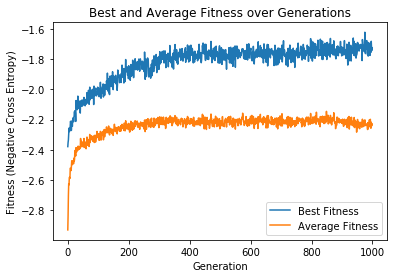

In [13]:
plt.plot(best_fitness, label = 'Best Fitness')
plt.plot(avg_fitness, label = 'Average Fitness')
plt.title('Best and Average Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness (Negative Cross Entropy)')
plt.legend()
plt.show()

## Plot Sizes over Generations

In [14]:
sizes = np.genfromtxt('NEAT-results/sizes_mnist.csv', delimiter='')
avg_nodes = sizes[:,0]
avg_connections = sizes[:,1]

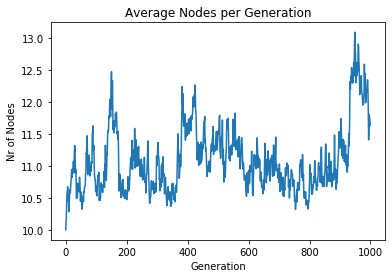

In [15]:
plt.plot(avg_nodes)
plt.title('Average Nodes per Generation')
plt.xlabel('Generation')
plt.ylabel('Nr of Nodes')
plt.show()

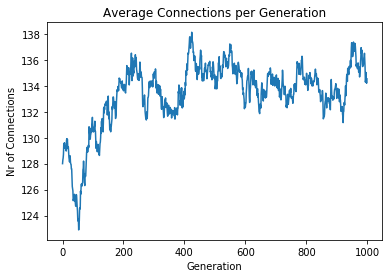

In [16]:
plt.plot(avg_connections)
plt.title('Average Connections per Generation')
plt.xlabel('Generation')
plt.ylabel('Nr of Connections')
plt.show()

## Load and Test Fittest Member

In [10]:
def test_fittest(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    preds_test = []
    preds_train = []
    train_correct = 0.
    test_correct = 0. 
    fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]
    #print(fittest_genome)
    net = neat.nn.FeedForwardNetwork.create(fittest_genome, config)
        
    for train, label in zip(X_train, Y_train):
        output = np.argmax(softmax(net.activate(train)))
        preds_train.append(output)
        if output == label:
            train_correct += 1.
    train_acc = train_correct / len(X_train)
    
    for test, label in zip(X_test, Y_test):
        output = np.argmax(softmax(net.activate(test)))
        preds_test.append(output)
        if output == label:
            test_correct += 1.
    test_acc = test_correct / len(X_test)
        
    print("Train Accuracy = {}".format(train_acc))
    print("Test Accuracy = {}".format(test_acc))
    
    return preds_train, preds_test

In [11]:
preds_train, preds_test = test_fittest(CONFIG_FILE)

Train Accuracy = 0.48861666666666664
Test Accuracy = 0.4912


In [12]:
cm_train = confusion_matrix(Y_train, preds_train, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, preds_test, labels=range(N_CLASSES_TO_USE))

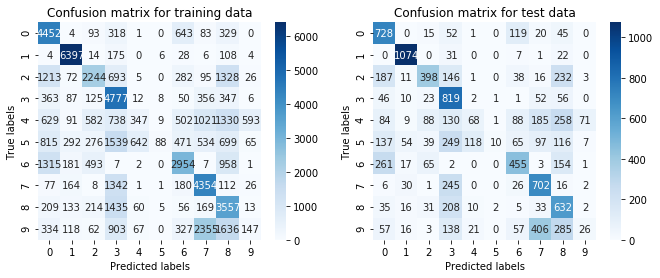

In [13]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for test data')

plt.savefig('confusion_neat_MNIST.png')
# Show the result
plt.show()

## Inspecting Fittest Genome

In [14]:
fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]

In [15]:
print(fittest_genome)

Key: 234689
Fitness: -1.6233370289874927
Nodes:
	0 DefaultNodeGene(key=0, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=0.0, response=1.0, activation=wsig, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=0.0, response=1.0, activation=abs, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	9 DefaultNodeGene(key=9, bias=0.0, response=1.0, activation=abs, aggregation=sum)
	57103 DefaultNodeGene(key=57103, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	57146 Default

In [16]:
used_input_pixels = []
for cg in fittest_genome.connections.values():
    if cg.enabled:
        used_input_pixels.append(cg.key[0])
print(used_input_pixels)

[-5, -54, -235, -19, -48, -218, -88, -235, -175, -252, -148, -86, -173, -151, -253, -224, -63, -250, -19, -29, -54, -108, -60, -66, -79, -227, -40, -22, -207, -195, -230, -109, -65, -184, -129, -158, -68, -124, -106, -124, -226, -239, -227, -108, -165, -92, -67, -232, -178, -178, -167, -39, -238, -166, -1, -248, -167, -27, -143, -166, -145, -5, -203, -43, -114, -73, -216, -136, -251, -189, -226, -157, -107, -207, -135, -36, -55, -14, -13, -253, -182, -165, 57103, -142, -19, 57146, -212]


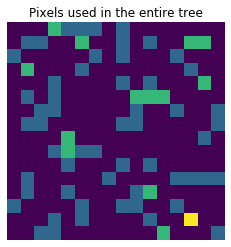

In [17]:
input_tallies = np.zeros(X_train.shape[1])
for arg in used_input_pixels:
    if arg <0:
        input_tallies[arg] += 1
plt.imshow( input_tallies.reshape(16,16) )
plt.title('Pixels used in the entire tree')
plt.axis('off')
plt.savefig('inputs_neat_MNIST.png')
plt.show()